# MP 1
### Emmanuel Gallegos
### CS 543: Computer Vision
### Prof. Svetlana Lazebnik
### University of Illinois Urbana Champaign

In [5]:
import time
import os
import cv2
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

In [98]:
# useful constants
UP=0
RIGHT=1
DOWN=2
LEFT=3

BLUE=0
GREEN=1
RED=2

COLOR_1 = RED
COLOR_2 = GREEN
COLOR_DEF = BLUE

WINDOW_SIZE = 15
CROP_AMOUNT = 50

WINDOW_SIZE_HIRES = 2
PYRAMID_LEVELS = 7
BORDER_CROP_FACTOR_HIRES = 0.1

In [7]:
# set image paths
basic_img_dir = os.path.join(os.getcwd(), "data")
hires_img_dir = os.path.join(os.getcwd(), "data_hires")
basic_img_paths = [os.path.join(basic_img_dir, img_path) for img_path in os.listdir(basic_img_dir)]
hires_img_paths = [os.path.join(hires_img_dir, img_path) for img_path in os.listdir(hires_img_dir)]
# make directory for colorized photos if it does not exist
basic_colorized_dir = os.path.join(basic_img_dir, "..", "basic_colorized")
hires_colorized_dir = os.path.join(hires_img_dir, "..", "hires_colorized")
if not os.path.exists(basic_colorized_dir):
    os.mkdir(basic_colorized_dir)
if not os.path.exists(hires_colorized_dir):
    os.mkdir(hires_colorized_dir)
basic_colorized_paths = [os.path.join(basic_colorized_dir, img_path) for img_path in os.listdir(basic_img_dir)]
hires_colorized_paths = [os.path.join(hires_colorized_dir, img_path) for img_path in os.listdir(hires_img_dir)]
print(basic_img_paths)
print(hires_img_paths)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(basic_colorized_paths)
print(hires_colorized_paths)

['D:\\HDD_Documents\\UIUC\\Fall_2022\\CV\\MP1\\data\\00125v.jpg', 'D:\\HDD_Documents\\UIUC\\Fall_2022\\CV\\MP1\\data\\00149v.jpg', 'D:\\HDD_Documents\\UIUC\\Fall_2022\\CV\\MP1\\data\\00153v.jpg', 'D:\\HDD_Documents\\UIUC\\Fall_2022\\CV\\MP1\\data\\00351v.jpg', 'D:\\HDD_Documents\\UIUC\\Fall_2022\\CV\\MP1\\data\\00398v.jpg', 'D:\\HDD_Documents\\UIUC\\Fall_2022\\CV\\MP1\\data\\01112v.jpg']
['D:\\HDD_Documents\\UIUC\\Fall_2022\\CV\\MP1\\data_hires\\01047u.tif', 'D:\\HDD_Documents\\UIUC\\Fall_2022\\CV\\MP1\\data_hires\\01657u.tif', 'D:\\HDD_Documents\\UIUC\\Fall_2022\\CV\\MP1\\data_hires\\01861a.tif']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
['D:\\HDD_Documents\\UIUC\\Fall_2022\\CV\\MP1\\data\\..\\basic_colorized\\00125v.jpg', 'D:\\HDD_Documents\\UIUC\\Fall_2022\\CV\\MP1\\data\\..\\basic_colorized\\00149v.jpg', 'D:\\HDD_Documents\\UIUC\\Fall_2022\\CV\\MP1\\data\\..\\basic_colorized\\00153v.jpg', 'D:\\HDD_Documents\\UIUC\\Fall_2022\\CV\\MP1\\data\\..\\basic_colorized\\0035

## Function definitions

In [90]:
# roll a 2d image in a given direction (0->up, 1->right, 2->down, 3->left)
def roll_image(image, direction, n_pixels):
    if direction == UP:
        return np.roll(image, -n_pixels, axis=0)
    elif direction == DOWN:
        return np.roll(image, n_pixels, axis=0)
    elif direction == RIGHT:
        return np.roll(image, n_pixels, axis=1)
    elif direction == LEFT:
        return np.roll(image, -n_pixels, axis=1)

# takes array of 3 grayscale images and normalizes each one to mean 0, unit norm
def normalize_image(bgr_image):
    # save shape of channel
    original_shape = bgr_image.shape
    # unroll the channels to 1d arrays
    unrolled_channels = bgr_image.reshape(3,-1)
    # get channel means
    means = np.mean(unrolled_channels, axis=1).reshape(-1,1)
    # subtract channel means to get mean 0 channels
    mean_0_channels = unrolled_channels - means
    # get channel norms
    norms = np.linalg.norm(mean_0_channels, axis=1).reshape(-1,1)
    # normalize channels
    norm_channels = mean_0_channels / norms  
    # reshape normalized arrays to original shape
    return norm_channels.reshape(original_shape)
    
# returns alignment indices (row, col) for normalized grayscale images
def get_alignment_indices(norm_channels):    
    # fit alignment of color1 and color2 channels to default color channel through exhaustive search
    best_col_1_val, best_col_2_val = 0, 0
    best_col_1_disp = (0,0)
    best_col_2_disp = (0,0)
    # roll color1 and color2 images up and to the left by 15 pixels
    norm_channels[COLOR_1] = roll_image(norm_channels[COLOR_1], UP, WINDOW_SIZE)
    norm_channels[COLOR_2] = roll_image(norm_channels[COLOR_2], UP, WINDOW_SIZE)
    norm_channels[COLOR_1] = roll_image(norm_channels[COLOR_1], LEFT, WINDOW_SIZE)
    norm_channels[COLOR_2] = roll_image(norm_channels[COLOR_2], LEFT, WINDOW_SIZE)
    # exhaustively search for best alignment
    # iterate over columns
    for col in range(-WINDOW_SIZE, WINDOW_SIZE+1):
        # iterate over rows
        for row in range(-WINDOW_SIZE, WINDOW_SIZE+1):
            # crop image (to avoid comparing wonky rolled borders)
            cropped_channels = norm_channels[:,CROP_AMOUNT:-CROP_AMOUNT,CROP_AMOUNT:-CROP_AMOUNT]
            # unroll
            unrolled_channels = cropped_channels.reshape(3,-1)
            # check color1's fit to color default
            color_1_fit = np.correlate(unrolled_channels[COLOR_1], unrolled_channels[COLOR_DEF]) #np.dot(norm_channels[COLOR_1], norm_channels[COLOR_DEF])
            # check color2's fit to color default
            color_2_fit = np.correlate(unrolled_channels[COLOR_2], unrolled_channels[COLOR_DEF]) #np.dot(norm_channels[COLOR_2], norm_channels[COLOR_DEF])
            # reroll
            #norm_channels = norm_channels.reshape(original_shape)     
            # update best displacements if needed
            if(color_1_fit > best_col_1_val):
                best_col_1_val = color_1_fit
                best_col_1_disp = (row,col)
            if(color_2_fit > best_col_2_val):
                best_col_2_val = color_2_fit
                best_col_2_disp = (row,col)
            # roll color1 and color2 images down 1 pixel
            norm_channels[COLOR_1] = roll_image(norm_channels[COLOR_1], DOWN, 1)
            norm_channels[COLOR_2] = roll_image(norm_channels[COLOR_2], DOWN, 1)
        # roll color1 and color2 images back up to top of window search area
        norm_channels[COLOR_1] = roll_image(norm_channels[COLOR_1], UP, 2 * WINDOW_SIZE + 1)
        norm_channels[COLOR_2] = roll_image(norm_channels[COLOR_2], UP, 2 * WINDOW_SIZE + 1)
        # roll color1 and color2 images to right by 1 pixel
        norm_channels[COLOR_1] = roll_image(norm_channels[COLOR_1], RIGHT, 1)
        norm_channels[COLOR_2] = roll_image(norm_channels[COLOR_2], RIGHT, 1)           
    
    # print displacement
    print("best color 1 displacement: " + str(best_col_1_disp))
    print("best color 2 displacement: " + str(best_col_2_disp))
    
    return (best_col_1_disp, best_col_2_disp)

# performs actual alignment of 3 grayscale images into rgb image based on best displacements for two colors
def align_bgr_image(bgr_image, best_col_1_disp, best_col_2_disp):    
    # roll original color 1 and color 2 images to optimal displacements
    bgr_image[COLOR_1] = roll_image(bgr_image[COLOR_1], DOWN, best_col_1_disp[0])
    bgr_image[COLOR_1] = roll_image(bgr_image[COLOR_1], RIGHT, best_col_1_disp[1])
    bgr_image[COLOR_2] = roll_image(bgr_image[COLOR_2], DOWN, best_col_2_disp[0])
    bgr_image[COLOR_2] = roll_image(bgr_image[COLOR_2], RIGHT, best_col_2_disp[1])   
    return bgr_image

# transforms bgr channels (shape 3,rows,cols) to rgb image (shape rows, cols, 3)
def bgr_channels_to_rgb_image(bgr_channels):
    # change stride from (3,r,c) to (r,c,3)
    bgr_image = bgr_channels.transpose(1,2,0)
    # flip channels from bgr to rgb channels
    rgb_image = np.flip(bgr_image, axis=-1)
    return rgb_image

# inverts the above transformation
def rgb_image_to_bgr_channels(rgb_image):
    bgr_image = np.flip(rgb_image, axis=-1)
    bgr_channels = bgr_image.transpose(2,0,1)
    return bgr_channels

# returns image pyramid from bgr_channel
def get_image_pyramid(bgr_channels, num_levels):
    # convert to rgb image
    rgb_image = bgr_channels_to_rgb_image(bgr_channels)
    # make image pyrmaid with num_levels levels
    height, width, channels = rgb_image.shape
    cur_height, cur_width = height // 2, width // 2
    pyramid = [rgb_image]
    for i in range(num_levels - 1):
        dims = (cur_width, cur_height)
        new_image = cv2.resize(rgb_image, dims, interpolation=cv2.INTER_AREA)
        pyramid.insert(0, new_image)
        cur_height, cur_width = cur_height // 2, cur_width // 2
    # convert images back to bgr channels
    channel_pyramid = [rgb_image_to_bgr_channels(image_level) for image_level in pyramid]
    return channel_pyramid

## Part 1

D:\HDD_Documents\UIUC\Fall_2022\CV\MP1\data\00125v.jpg
best color 1 displacement: (12, 1)
best color 2 displacement: (6, 2)
(342, 400, 3)
D:\HDD_Documents\UIUC\Fall_2022\CV\MP1\data\00149v.jpg
best color 1 displacement: (11, 2)
best color 2 displacement: (5, 2)
(342, 397, 3)
D:\HDD_Documents\UIUC\Fall_2022\CV\MP1\data\00153v.jpg
best color 1 displacement: (15, 5)
best color 2 displacement: (8, 3)
(342, 394, 3)
D:\HDD_Documents\UIUC\Fall_2022\CV\MP1\data\00351v.jpg
best color 1 displacement: (15, 1)
best color 2 displacement: (5, 1)
(342, 396, 3)
D:\HDD_Documents\UIUC\Fall_2022\CV\MP1\data\00398v.jpg
best color 1 displacement: (13, 4)
best color 2 displacement: (6, 3)
(342, 397, 3)
D:\HDD_Documents\UIUC\Fall_2022\CV\MP1\data\01112v.jpg
best color 1 displacement: (7, 1)
best color 2 displacement: (1, 0)
(342, 393, 3)


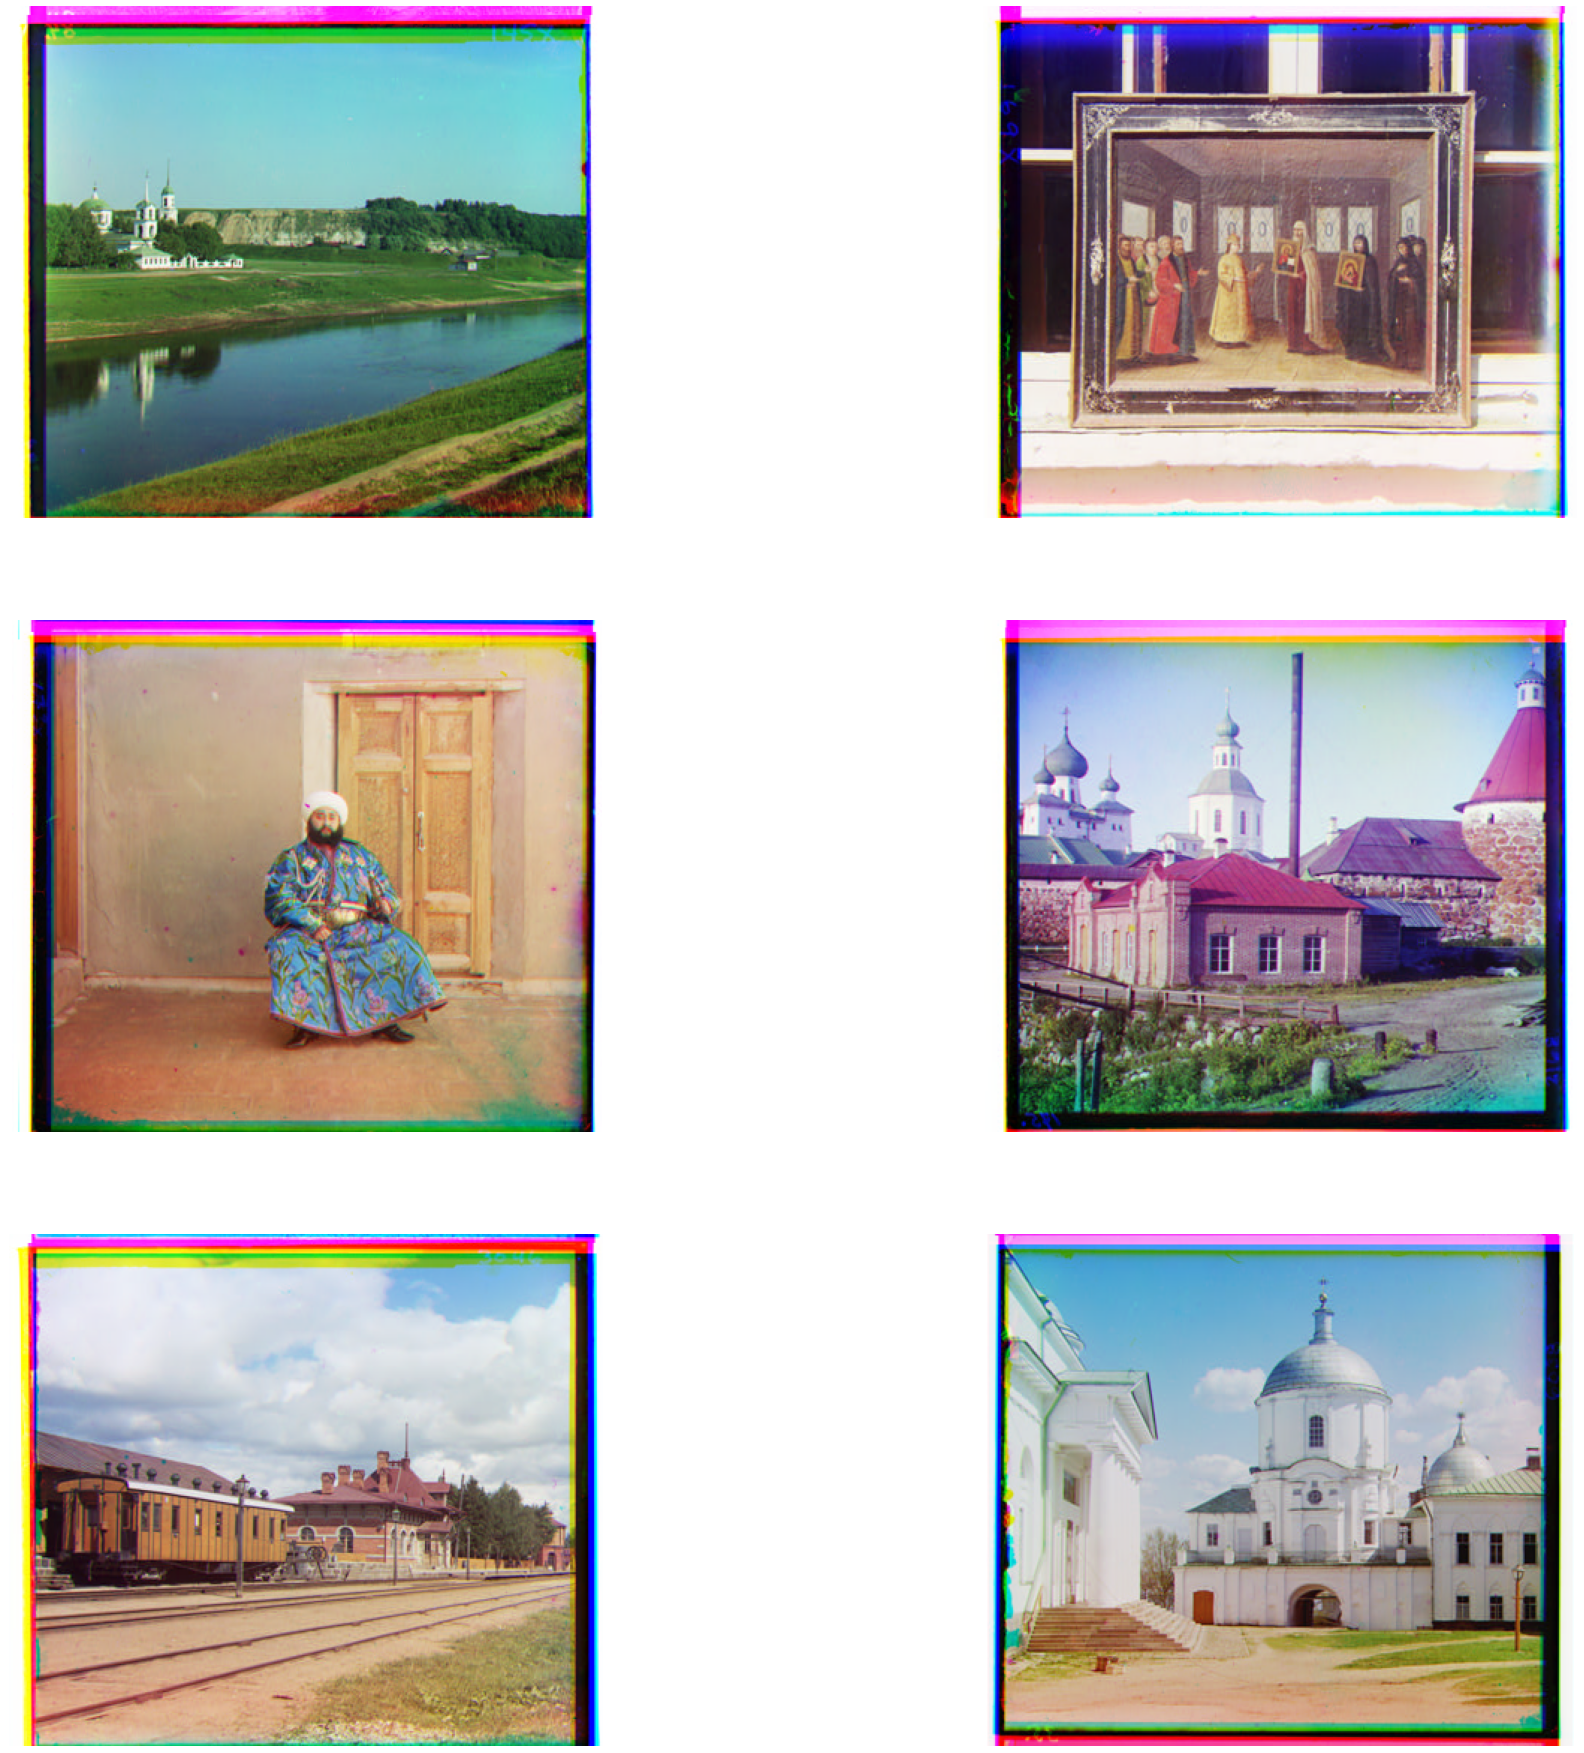

In [79]:
 # create figure
fig = plt.figure(figsize=(32, 32))
rows = 3
columns = 2

for n in range (0,len(basic_img_paths)): 
    print(basic_img_paths[n])
    # open image
    image = Image.open(basic_img_paths[n])
    grayscale_img = image.convert("L")
    # image to numpy array
    np_img = np.array(image)
    # ensure n_rows is multiple of 3
    while np_img.shape[0] % 3 != 0:
        np_img = np.pad(np_img, ((0,1),(0,0)), mode='constant', constant_values=255)
    # get 3 channel images
    bgr_channels = np.array(np.array_split(np_img, 3))
    # normalize images
    norm_channels = normalize_image(bgr_channels)
    # get alignment indices
    alignment_indices = get_alignment_indices(norm_channels)
    # align image
    aligned_image = align_bgr_image(bgr_channels, alignment_indices[0], alignment_indices[1])
    # transform to rbg image
    rgb_image = bgr_channels_to_rgb_image(aligned_image)
    # display image
    fig.add_subplot(rows, columns, n+1)
    plt.axis('off')
    plt.imshow(rgb_image)
    # save image
    im = Image.fromarray(rgb_image)
    im.save(basic_colorized_paths[n])

## Part 2

In [80]:
# @param norm_channels - mean 0, unit norm channel bgr image of shape (3,n_rows,n_cols)
# @param starting_best_values - the 'best' fit values we have found thus far (best_fit_COLOR1, best_fit_COLOR2)
# @param starting_disp_col_1 - displacements from which to start search for color 1 (COLOR1_ROW, COLOR1_COL)
# @param starting_disp_col_2 - displacements from which to start search for color 2 (COLOR2_ROW, COLOR2_COL)
# @return best fit scores and alignment displacements FROM STARTING DISPLACEMENTS (row, col) 
def get_alignment_results_hires(norm_channels, starting_best_values, starting_disp_col_1, starting_disp_col_2):    
    # set initial best fit values and displacements FROM best starting values
    best_col_1_val, best_col_2_val = starting_best_values[0], starting_best_values[1]
    best_col_1_disp, best_col_2_disp = (0,0), (0,0)
    # roll color1 and color2 images to their known best starting displacements
    norm_channels[COLOR_1] = roll_image(norm_channels[COLOR_1], DOWN, starting_disp_col_1[0])
    norm_channels[COLOR_1] = roll_image(norm_channels[COLOR_1], RIGHT, starting_disp_col_1[1])
    norm_channels[COLOR_2] = roll_image(norm_channels[COLOR_2], DOWN, starting_disp_col_2[0])
    norm_channels[COLOR_2] = roll_image(norm_channels[COLOR_2], RIGHT, starting_disp_col_2[1])
    # roll color1 and color2 images up and to the left by WINDOW_SIZE_HIRES pixels
    norm_channels[COLOR_1] = roll_image(norm_channels[COLOR_1], UP, WINDOW_SIZE_HIRES)
    norm_channels[COLOR_2] = roll_image(norm_channels[COLOR_2], UP, WINDOW_SIZE_HIRES)
    norm_channels[COLOR_1] = roll_image(norm_channels[COLOR_1], LEFT, WINDOW_SIZE_HIRES)
    norm_channels[COLOR_2] = roll_image(norm_channels[COLOR_2], LEFT, WINDOW_SIZE_HIRES)
    # exhaustively search for best alignment for color 1
    # iterate over columns
    for col in range(-WINDOW_SIZE_HIRES, WINDOW_SIZE_HIRES+1):
        # iterate over rows
        for row in range(-WINDOW_SIZE_HIRES, WINDOW_SIZE_HIRES+1):
            # crop image (to avoid comparing wonky rolled borders)
            cropped_channels = norm_channels[:,CROP_AMOUNT_HIRES:-CROP_AMOUNT_HIRES,CROP_AMOUNT_HIRES:-CROP_AMOUNT_HIRES]
            # unroll
            unrolled_channels = cropped_channels.reshape(3,-1)
            # check color1's fit to color default
            color_1_fit = np.correlate(unrolled_channels[COLOR_1], unrolled_channels[COLOR_DEF])
            # check color2's fit to color default
            color_2_fit = np.correlate(unrolled_channels[COLOR_2], unrolled_channels[COLOR_DEF])
            # reroll
            #norm_channels = norm_channels.reshape(original_shape)     
            # update best displacements if needed
            if(color_1_fit > best_col_1_val):
                best_col_1_val = color_1_fit
                best_col_1_disp = (row, col)
            if(color_2_fit > best_col_2_val):
                best_col_2_val = color_2_fit
                best_col_2_disp = (row,col)
            # roll color1 and color2 images down 1 pixel
            norm_channels[COLOR_1] = roll_image(norm_channels[COLOR_1], DOWN, 1)
            norm_channels[COLOR_2] = roll_image(norm_channels[COLOR_2], DOWN, 1)
        # roll color1 and color2 images back up to top of window search area
        norm_channels[COLOR_1] = roll_image(norm_channels[COLOR_1], UP, 2 * WINDOW_SIZE_HIRES + 1)
        norm_channels[COLOR_2] = roll_image(norm_channels[COLOR_2], UP, 2 * WINDOW_SIZE_HIRES + 1)
        # roll color1 and color2 images to right by 1 pixel
        norm_channels[COLOR_1] = roll_image(norm_channels[COLOR_1], RIGHT, 1)
        norm_channels[COLOR_2] = roll_image(norm_channels[COLOR_2], RIGHT, 1)     
    
    # print displacement
    print("best color 1 displacement: " + str(best_col_1_disp))
    print("best color 2 displacement: " + str(best_col_2_disp))
    
    return (color_1_fit, color_2_fit, best_col_1_disp, best_col_2_disp)


## Naive method:
Cropped large images to 400x400 pixels and used basic alignment strategy on cropped images to inform how to align the bigger images

(Known correct answer for part 1 from silly cropped method):
best color 1 displacement: (73, 34)
best color 2 displacement: (25, 20)

Rounded alignment times for basic alignment method on cropped images: 66, 68, 68 (seconds)

## Image Pyramid:

D:\HDD_Documents\UIUC\Fall_2022\CV\MP1\data_hires\01047u.tif
(3, 40, 46)
best color 1 displacement: (1, 0)
best color 2 displacement: (0, 0)
(3, 80, 93)
best color 1 displacement: (0, 1)
best color 2 displacement: (1, 1)
(3, 161, 187)
best color 1 displacement: (1, 0)
best color 2 displacement: (0, -1)
(3, 322, 374)
best color 1 displacement: (-1, 0)
best color 2 displacement: (-1, 1)
(3, 644, 748)
best color 1 displacement: (0, 0)
best color 2 displacement: (0, -1)
(3, 1288, 1496)
best color 1 displacement: (1, 1)
best color 2 displacement: (0, 0)
(3, 2577, 2993)
best color 1 displacement: (-1, -1)
best color 2 displacement: (1, 0)
Alignment time: 5.155001401901245
final color 1 displacement: (73, 33)
final color 2 displacement: (25, 20)
D:\HDD_Documents\UIUC\Fall_2022\CV\MP1\data_hires\01657u.tif
(3, 40, 47)
best color 1 displacement: (2, 0)
best color 2 displacement: (1, 0)
(3, 80, 94)
best color 1 displacement: (-1, 0)
best color 2 displacement: (0, 0)
(3, 160, 188)
best color 1 di

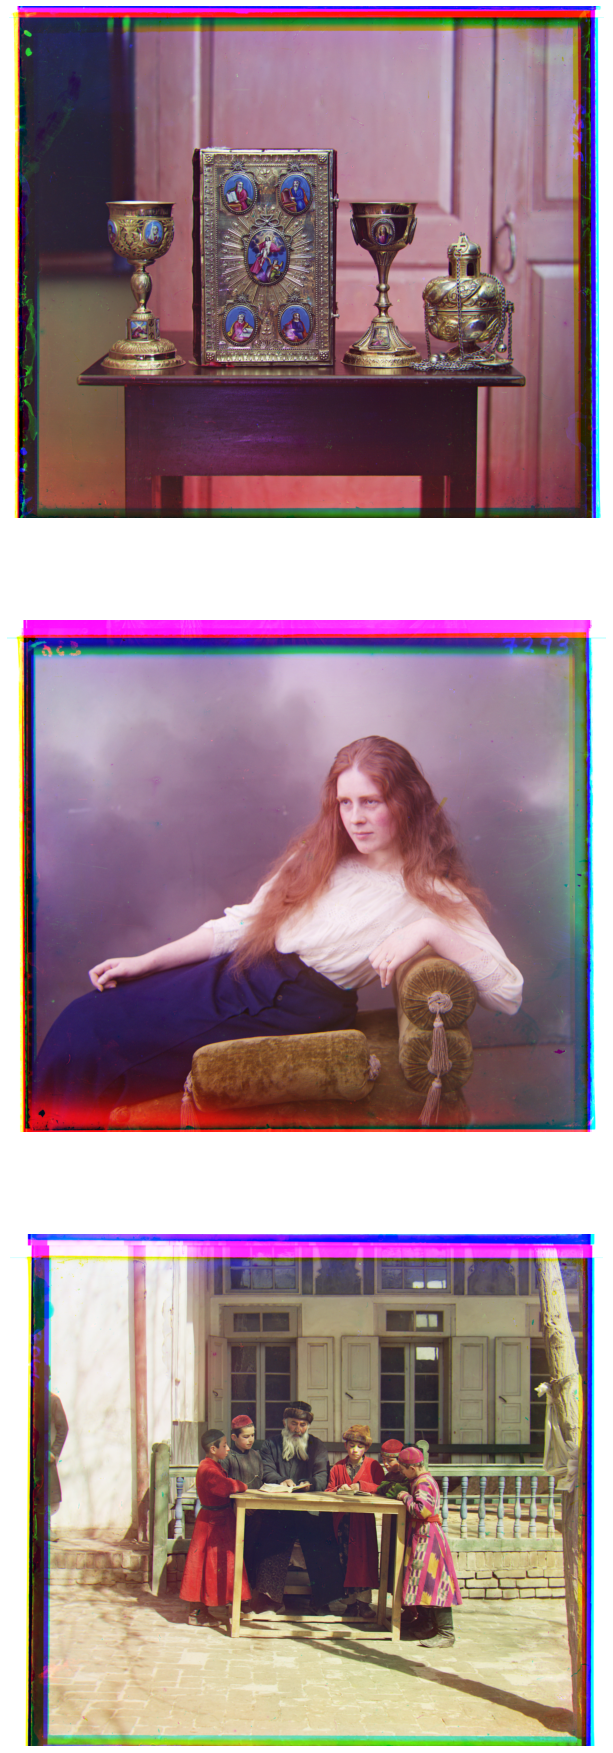

In [100]:
fig = plt.figure(figsize=(32, 32))
rows = 3
columns = 1

Image.MAX_IMAGE_PIXELS = None

for n in range (0, len(hires_img_paths)):
    print(hires_img_paths[n])
    # open image
    image = Image.open(hires_img_paths[n])
    grayscale_img = image.convert("L")
    # image to numpy array
    np_img = np.array(image)
    # ensure n_rows is multiple of 3
    while np_img.shape[0] % 3 != 0:
        np_img = np.pad(np_img, ((0,1),(0,0)), mode='constant', constant_values=0)
    # get 3 channel images
    bgr_channels = np.array(np.array_split(np_img, 3))
    
    # crop 10% off the top bottom left and right of each image to eliminate the black border
    three, num_rows, num_columns = bgr_channels.shape
    side_border = int(BORDER_CROP_FACTOR_HIRES * num_columns)
    top_border = int(BORDER_CROP_FACTOR_HIRES * num_rows)
    cropped_channels = bgr_channels[:,top_border:-top_border,side_border:-side_border]
    
    # generate image pyramid from cropped channels
    img_pyramid = get_image_pyramid(cropped_channels, PYRAMID_LEVELS)
    
    # normalize images to mean 0 and unit norm
    norm_pyramid = [normalize_image(img_pyramid[i]) for i in range(len(img_pyramid))]
    
    # set preconditions
    best_values = (0,0)
    best_disp_col_1, best_disp_col_2 = (0,0), (0,0)
    images_aligned = False
    i = 0
    
    # timing
    start_time = time.time()
    
    # perform alignment
    while(i < PYRAMID_LEVELS and not images_aligned):
        print(norm_pyramid[i].shape)
        new_color_1_fit, new_color_2_fit, new_col_1_disp, new_col_2_disp = get_alignment_results_hires(norm_pyramid[i], best_values, best_disp_col_1, best_disp_col_2)
        # if no changes made, we are done
        if new_col_1_disp == (0,0) and new_col_2_disp == (0,0):
            print("Done aligning, best fit values: " + str(best_values))
            images_aligned = True
            # scale up indices by 2 ^ number of levels in the pyramid remaining
            best_disp_col_1 = best_disp_col_1[0] * (2 ** (PYRAMID_LEVELS - i - 1)), best_disp_col_1[1] * (2 ** (PYRAMID_LEVELS - i - 1))
            best_disp_col_2 = best_disp_col_2[0] * (2 ** (PYRAMID_LEVELS - i - 1)), best_disp_col_2[1] * (2 ** (PYRAMID_LEVELS - i - 1))
        else:
            best_values = (new_color_1_fit, new_color_2_fit)
            # add new displacements (scaled up by 2) to current best displacement indices
            best_disp_col_1 = ((best_disp_col_1[0] + new_col_1_disp[0]) * 2, (best_disp_col_1[1] + new_col_1_disp[1]) * 2)
            best_disp_col_2 = ((best_disp_col_2[0] + new_col_2_disp[0]) * 2, (best_disp_col_2[1] + new_col_2_disp[1]) * 2)
        # stop if we have exhausted the pyramid
        i += 1
    # if we did not perfectly align in the outer step, undo the last multiplication by 2    
    if not images_aligned:
        best_disp_col_1 = best_disp_col_1[0] // 2, best_disp_col_1[1] // 2
        best_disp_col_2 = best_disp_col_2[0] // 2, best_disp_col_2[1] // 2
    
    # timing
    end_time = time.time()
    total_time = end_time - start_time
    
    print("Alignment time: " + str(total_time))
    print("final color 1 displacement: " + str(best_disp_col_1))
    print("final color 2 displacement: " + str(best_disp_col_2))
    
    # align original (uncropped) image
    aligned_image = align_bgr_image(bgr_channels, best_disp_col_1, best_disp_col_2)
    # to rgb
    rgb_image = bgr_channels_to_rgb_image(aligned_image)
    # to values between 0 and 255
    rgb_image = ((rgb_image / np.max(rgb_image)) * 255).astype(np.uint8)
    # display image
    fig.add_subplot(rows, columns, n+1)
    plt.axis('off')
    plt.imshow(rgb_image)
    # save image
    im = Image.fromarray(rgb_image)
    im.save(hires_colorized_paths[n], save_all=True)